Class distribution:
Binary_Class
0    3493
1     523
Name: count, dtype: int64
Class weights: {0: 0.5741866285305685, 1: 3.869879518072289}
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.5040 - loss: 1.4100 - val_accuracy: 0.4557 - val_loss: 0.7504
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.4523 - loss: 0.7804 - val_accuracy: 0.1477 - val_loss: 0.7757
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.6357 - loss: 0.6975 - val_accuracy: 0.1353 - val_loss: 0.7583
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.5033 - loss: 0.6706 - val_accuracy: 0.4759 - val_loss: 0.6991
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.3100 - loss: 0.6889 - val_accuracy: 0.6205 - val_loss: 0.6460
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.3777 - loss: 0.6727 - val_accuracy: 0.6734 - val_loss: 0.5697
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.4256 - loss: 0.7115 - val_accuracy: 0.6221 - val_loss: 0.6340
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.4792 - loss: 0.7028 - val_accuracy: 0.8631 - val_lo

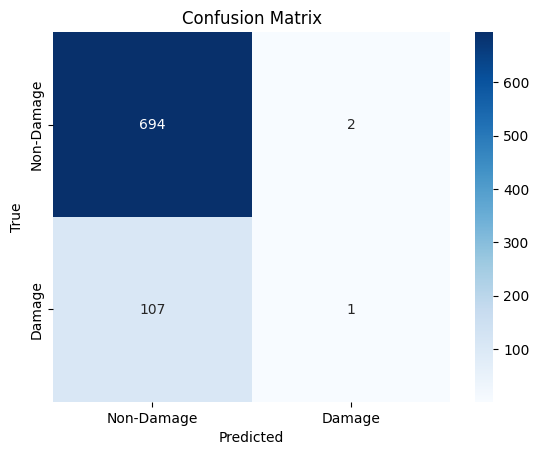

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from gensim.models import Word2Vec
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the CSV file
file_path = '/Hurricane_irma_modified.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# Load and preprocess data
data = pd.read_csv(file_path)
if 'processed_data' not in data.columns or 'Binary_Class' not in data.columns:
    raise KeyError("The dataset must contain 'processed_data' and 'Binary_Class' columns.")

data['processed_data'] = data['processed_data'].fillna('').astype(str)
data['Binary_Class'] = data['Binary_Class'].map({'Non-Damage': 0, 'Damage': 1})

# Check class distribution
print("Class distribution:")
print(data['Binary_Class'].value_counts())

# Tokenize and split data
sentences = [sentence.split() for sentence in data['processed_data']]
labels = data['Binary_Class'].values
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, sg=0)

# Create embedding matrix
vocab_size = len(word2vec_model.wv.index_to_key)
embedding_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

word_index = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}
for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

X_train = [[word_index.get(word, 0) for word in sentence] for sentence in X_train]
X_test = [[word_index.get(word, 0) for word in sentence] for sentence in X_test]
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=100)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=100)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights_dict)

# Define and train the CNN model
model = Sequential([
    Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=X_train.shape[1], trainable=False),
    Conv1D(100, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.02),
    Conv1D(150, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=3),
    BatchNormalization(),
    Dropout(0.02),
    Conv1D(200, kernel_size=4, activation='relu'),
    MaxPooling1D(pool_size=4),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])

# Evaluate model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=1))
print("Recall:", recall_score(y_test, y_pred, zero_division=1))
print("F1 Score:", f1_score(y_test, y_pred, zero_division=1))

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Damage', 'Damage'], yticklabels=['Non-Damage', 'Damage'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
